In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [3]:
down_sample_factor = 1  # currently doing nothing 
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [4]:
len(pch)

39

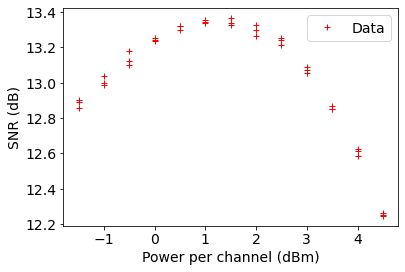

In [5]:
plt.plot(pch, snr, 'r+', label='Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

Select a fraction of the data to use for fitting and another fraction for testing.

In [23]:
snr_fit = snr[:-9].reshape(-1,1)
pch_fit = pch[:-9].reshape(-1,1)

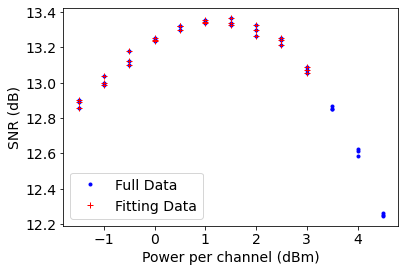

In [24]:
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_fit, snr_fit, 'r+', label='Fitting Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [25]:
class GN_model:
    def __init__(self, span_len, lam_op, num_lam, nl_cof, disp_cof,  alpha, r_sym, bchrs, grid_sp, n_fig, num_spans):
        self.span_len = span_len
        self.lam_op = lam_op
        self.num_lam = num_lam
        self.nl_cof = nl_cof
        self.disp_cof = disp_cof
        self.alpha = alpha
        self.r_sym = r_sym
        self.bchrs = bchrs
        self.grid_sp = grid_sp
        self.n_fig = n_fig
        self.num_spans = num_spans
        self.freq = 299792458/(self.lam_op*1e-9)
        self.al_lin = np.log((10**(self.alpha/10)))/2 # fibre loss [1/km] 
        self.beta2 = (self.disp_cof*(self.lam_op**2))/(2*np.pi*299792.458) # dispersion coefficient at given wavelength [ps^2/km]
        self.l_eff = (1 - np.exp(-2*self.al_lin*self.span_len ))/(2*self.al_lin) # effective length [km]
        self.l_eff_as = 1/(2*self.al_lin) # the asymptotic effective length [km]  
        self.h = 6.63*1e-34 # Planck's constant [Js]
        self.Bwdm = self.bchrs * self.num_lam ** ( self.bchrs / self.grid_sp )  # channel BW [GHz]
        self.epsilon = 0.3*np.log(1 + ( 6 * self.l_eff_as ) / ( self.span_len * np.arcsinh( 0.5*np.pi**2 * self.beta2 *self.l_eff_as * self.Bwdm**2 )  )  )
    def predict_snr(self, p_ch):
        Gwdm = (1e-3*self.convert_to_lin(p_ch))/(self.bchrs*1e9)  # [W]
        Gnli = (1e24*(8/27)*(self.nl_cof**2)*(Gwdm**3)*(self.l_eff**2) ) /(np.pi*self.beta2*self.l_eff_as)  *  (np.arcsinh((np.pi**2)*0.5*self.beta2*self.l_eff_as*(self.bchrs**2)*(self.num_lam**((2*self.bchrs)/self.grid_sp))  ) )*self.num_spans**(1 + self.epsilon)                                                                             
        Pase = self.n_fig*self.h*self.freq*(self.convert_to_lin(self.alpha*self.span_len) - 1)*self.bchrs*1e9*self.num_spans       
        Pch = 1e-3*10**(p_ch/10) 
        snr = (Pch/(Pase + Gnli*self.bchrs*1e9))
        snr = self.apply_trx_b2b(snr, 16.5)
        #snr = ( snr**(-1) + (self.convert_to_lin(16.5))**(-1) )**(-1)
        return self.convert_to_db(snr)
    def find_pch_opt(self):  # return optimal Pch in dBm
        PchdBm = np.linspace(-6,6,500)  # 500 datapoints for higher resolution of Pch
        numpch = len(PchdBm)
        Pchsw = 1e-3*10**(PchdBm/10)  # convert from dBm to linear units [W]
        Gwdmsw = Pchsw/(self.bchrs*1e9)
        Gnlisw = (1e24*(8/27)*(self.nl_cof**2)*(Gwdmsw**3)*(self.l_eff**2) ) /(np.pi*self.beta2*self.l_eff_as)  *  (np.arcsinh((np.pi**2)*0.5*self.beta2*self.l_eff_as*(self.bchrs**2)*(self.num_lam**((2*self.bchrs)/self.grid_sp))  ) )                                                                            
        G = self.alpha*self.span_len
        NFl = 10**(self.n_fig/10) # convert to linear noise figure
        Gl = 10**(G/10) # convert to linear gain
        Pasesw = NFl*self.h*self.freq*(Gl - 1)*self.bchrs*1e9 # [W] the ASE noise power in one Nyquist channel across all spans
        snrsw = (Pchsw)/(Pasesw*np.ones(numpch) + Gnlisw*self.bchrs*1e9)
        return PchdBm[np.argmax(snrsw)]
    def apply_trx_b2b(self, snr, snr_pen):
        return ( snr**(-1) + (self.convert_to_lin(16.5))**(-1) )**(-1)
    def convert_to_lin(self, x):
        return 10**(x/10)
    def convert_to_db(self, x):
        return 10*np.log10(x)

**Inputs**: span length [km], operating central wavelength [nm], number of wavelengths, nonlinearity coefficient[1/(W*km)], dispersion coefficient[ps^2/km], loss [db/km], symbol rate [GBd], channel bandwidth [GHz], grid spacing [GHz], EDFA noise figure [dB], number of spans 

In [26]:
phys_model = GN_model(100, 1550, 1, 1.1, 18, 0.18, 35, 40.2, 50, 4, 10)

According to Javier, the measurements of Pch may not be reliable and we may need to shift them in order to obtain agreement with the GN model. We do this by calculating the input power per channel that corresponds to peak SNR in the GN model and shifting the peak of measured data to line up with this prediction.

In [27]:
pch_gn = np.linspace(-5, 5, 100)
pch_fit_shifted = pch_fit - (1.25 - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
pch_shifted = pch - (1.25 - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
snr_phys = phys_model.predict_snr(pch_fit_shifted).reshape(-1,1)

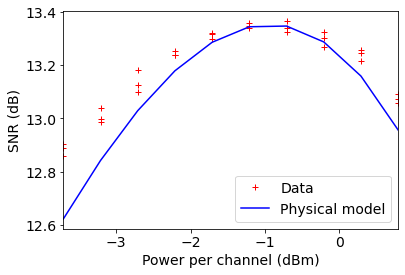

In [28]:
plt.plot(pch_fit_shifted, snr_fit, 'r+', label='Data')
plt.plot(pch_fit_shifted, snr_phys, 'b-', label='Physical model')
plt.xlim([pch_fit_shifted[0], pch_fit_shifted[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
#plt.savefig('powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

Need to think about how many datapoints I will use for the physical model - ideally dont want to use the same number of datapoints as the data as then we dont get the benefit for a low number of points... 

In [44]:
num_points_phys = 50
#pch_test = np.linspace(pch_fit_shifted[0], pch_fit_shifted[-1], 50).reshape(-1,1) 
pch_test = np.linspace(pch_shifted[0], pch_shifted[-1], num_points_phys).reshape(-1,1) 
snr_phys_test = phys_model.predict_snr(pch_test).reshape(-1,1)

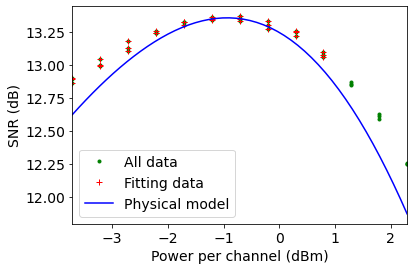

In [45]:
#plt.plot(pch_shifted[-9:], snr[-9:], 'g.', label='All data')
plt.plot(pch_shifted, snr, 'g.', label='All data')
plt.plot(pch_fit_shifted, snr_fit, 'r+', label='Fitting data')
plt.plot(pch_test, snr_phys_test, 'b-', label='Physical model')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
#plt.savefig('powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [46]:
pch_fit_shifted = pch_fit_shifted.reshape(-1, 1)  # needed for SK learn input
#pch_predict = np.linspace(pch_shifted[0], pch_shifted[-1] + 1.0)
pch_shifted = pch_shifted.reshape(-1,1)
kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-8,1e5))
gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_phys.fit_phys(pch_fit_shifted, pch_test, snr_fit, snr_phys_test)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_shifted, return_std=True)
std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
theta_phys = gpr_phys.kernel_.theta
lml_phys = gpr_phys.log_marginal_likelihood()
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [47]:
pch_fit_shifted = pch_fit_shifted.reshape(-1, 1)  # needed for SK learn input
pch_shifted = pch_shifted.reshape(-1, 1)  # needed for SK learn input
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-8,1e5))
gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr.fit(pch_fit_shifted, snr_fit)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk, std_sk = gpr.predict(pch_shifted, return_std=True)
std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
theta = gpr.kernel_.theta
lml = gpr.log_marginal_likelihood()
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

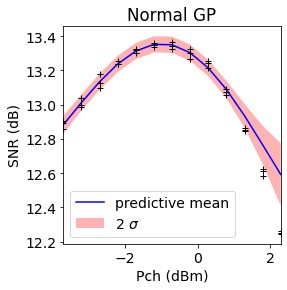

In [48]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'predictive mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Normal GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

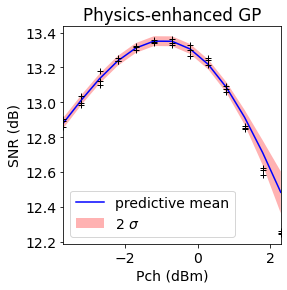

In [49]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'predictive mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Physics-enhanced GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

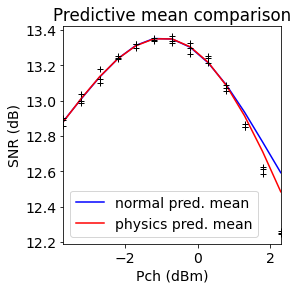

In [51]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'normal pred. mean')
ax.plot(pch_shifted, mu_sk_phys, 'r-', label = 'physics pred. mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Predictive mean comparison")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('.pdf', dpi=200,bbox_inches='tight')
plt.show()

This is not entirely unexpected - we have used a physical model to help bias the kernel parameters towards a model that makes more sense beyond the range of the dataset. We gave the model data only from the **linear regime** and then tried to predict in the **non-linear regime**. In the case where we give the model an idea of the physics of the system, it performs much better in this regime (but still not perfectly...). 
This is a promising step in the right direction. 

In [52]:
max(std_sk)

array([0.09092135])

In [53]:
max(std_sk_phys)

array([0.05994224])

Relative change in the predictive std (%):

In [54]:
100*(max(std_sk_phys) - max(std_sk))/max(std_sk)

array([-34.07243127])

Initial results - see a drop in the predictive std of the model, likely because more datapoints used in fitting. 

RMSD of the predictive mean of the model with and without physical models:

In [57]:
np.mean(((mu_sk - mu_sk_phys)**2)**0.5)

0.030756374025023465

Mean relative difference (%):

In [58]:
np.mean(100*(mu_sk - mu_sk_phys)/mu_sk)

0.22788241074975124

In [133]:
np.exp(theta)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + I sigma**2 

array([1.48634509e+01, 5.01039866e+00, 8.56118623e-05])

In [134]:
np.exp(theta_phys)

array([1.94948053e+01, 5.45537685e+00, 3.39254300e-05])

Some observations:
* Difference in the noise level: reduced in the physical model case, this is reflected in the predictive std of the model
* The predictive mean of the models when the physical model information is given over the same range is the same to within a small amount but the mu and l parameters of the RBF kernel are different - a different local minimum has been found as the LML function used in optimisation was different (biased by the physical model) 
* Should note that the physics-enhanced model appears to be over-confident, as more points than you would expect lie outside of the 2 sigma confidence region (we expect ~3.5) as 2 sigma is roughly 95%. 